In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import json

## 퀀트함수
from quant_functions import anal_funcs, data_funcs
import portfolio_obtimizer
import myfuncs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
## figure size 설정
figsize=(12, 8)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import graphModule as gm

## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

# 블루 테마
cmap_colors = ["#FFFFFF", mycolors['color_cont3'], mycolors['color_cont2']]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)    

## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)

## DataLoad

In [2]:
## 보간용 필수 데이터
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
div = pd.read_csv(f"div.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Div'})
div.index = pd.to_datetime(div.index)
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')
ds2 = fred.get_series('DGS2').fillna(method='pad')
tb3 = fred.get_series('DTB3').fillna(method='pad')
dff = fred.get_series('DFF').fillna(method='pad')

In [56]:
## load data
df_ref = data_funcs.get_merged_df('^IXIC', '^GSPC', '^DJI', 'GC=F')

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref.fillna(method = 'pad')
df_ref['Div'] = div['Div']
df_ref['Gold'] = gold['Gold']
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20
df_ref['DGS2'] = ds2
df_ref['DTB3'] = tb3

## Imputation
df_ref = myfuncs.imputation(df_ref, '^GSPC', '^DJI')
df_ref = myfuncs.imputation(df_ref, '^DJI', 'Div')
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS20', log_diff=False)
df_ref = myfuncs.imputation(df_ref, 'DGS20', 'DGS10', log_diff=False)
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS2', log_diff=False)
df_ref = myfuncs.imputation(df_ref, 'DGS2', 'DTB3', log_diff=False)
df_ref = myfuncs.imputation(df_ref, 'GC=F', 'Gold')
df_ref['Gold']['1975-01-02'] = 1
df_ref['Gold']['1975-01-03'] = 1

## column selection
df_ref = df_ref[['^GSPC', '^DJI', '^IXIC', 'Div', 'Gold', 'DTB3', 'DGS2', 'DGS10', 'DGS20']]
_cols = ['^GSPC', '^DJI', '^IXIC', 'Div', 'Gold']
df_ref[_cols] = df_ref[_cols]/df_ref[_cols].iloc[0]
df_ref.columns = ['S&P500', 'DowJones', 'NASDAQ', 'Div', 'Gold', 'DTB3', 'DGS2', 'DGS10', 'DGS20']
df_ref['Cash'] = (df_ref['DTB3']/100 * 1/252 + 1).cumprod()

[*********************100%%**********************]  4 of 4 completed


0.9188454428374512
0.8698779253276526
0.8863286372475352
1.015270798927883
0.6625151443142865
0.7094283309432939
0.9953424146502147


In [57]:
## 프로젝트마다 필요한 데이터
tickers = ['SCHD', 'TLT', 'SGOV']
df_ori = data_funcs.get_merged_df(*tickers)
df_ori = df_ori[tickers]

[*********************100%%**********************]  3 of 3 completed


In [76]:
## 보간 시계열 데이터
df_imp = pd.concat([df_ref, df_ori], axis=1)
df_imp = myfuncs.imputation(df_imp, 'Div', 'SCHD')
df_imp = myfuncs.imputation(df_imp, 'DGS20', 'TLT')
df_imp = myfuncs.imputation(df_imp, 'Cash', 'SGOV')

## 비보간 시계열 데이터
df_cut = df_imp[df_ori.dropna().index[0]:]
df_cut = df_cut/df_cut.iloc[0]

0.9966109284688056
-0.30355265779727714
0.9945389716443662


In [75]:
assets = ['SCHD', 'TLT', 'SGOV']

In [79]:
plot_df = df_imp.copy()
# plot_df = df_imp['1999':].copy()
# plot_df = df_cut[:]
plot_df = plot_df/plot_df.iloc[0]
highlight_periods = [(shock_cases['1차오일쇼크_t0'], shock_cases['1차오일쇼크_t1']),
                     (shock_cases['2차오일쇼크_t0'], shock_cases['2차오일쇼크_t1']),
                     (shock_cases['물가충격_t0'], shock_cases['물가충격_t1']),
                     (shock_cases['걸프전_t0'], shock_cases['걸프전_t1']),
                     (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
                     (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
                     (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

# highlight_periods = [
#                      (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
#                      (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
#                      (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

# highlight_periods = [(shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

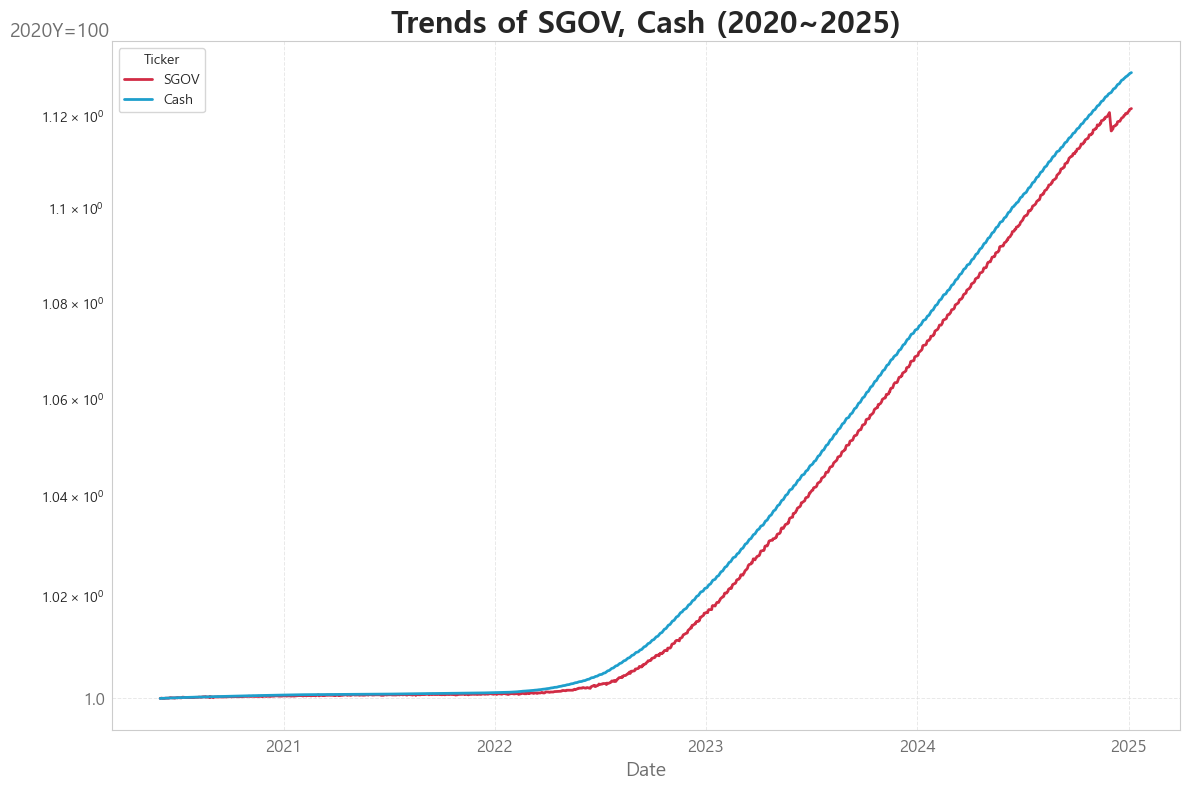

In [85]:
gm.trend_plot(df_cut, ['SGOV', 'Cash'], highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont']])

In [89]:
assets

['SCHD', 'TLT', 'SGOV']

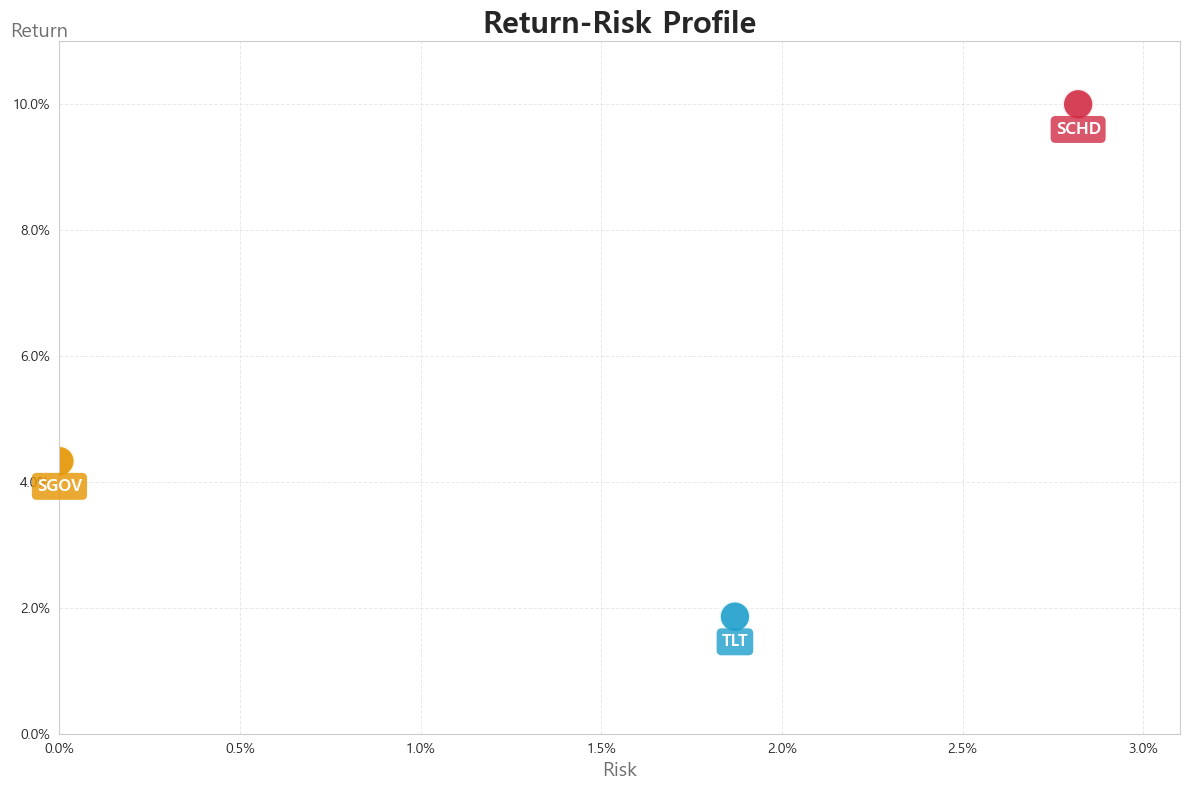

In [90]:
return_risk_df = anal_funcs.get_Vol_report(plot_df[assets], method='a', rf=0)
# gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])
gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

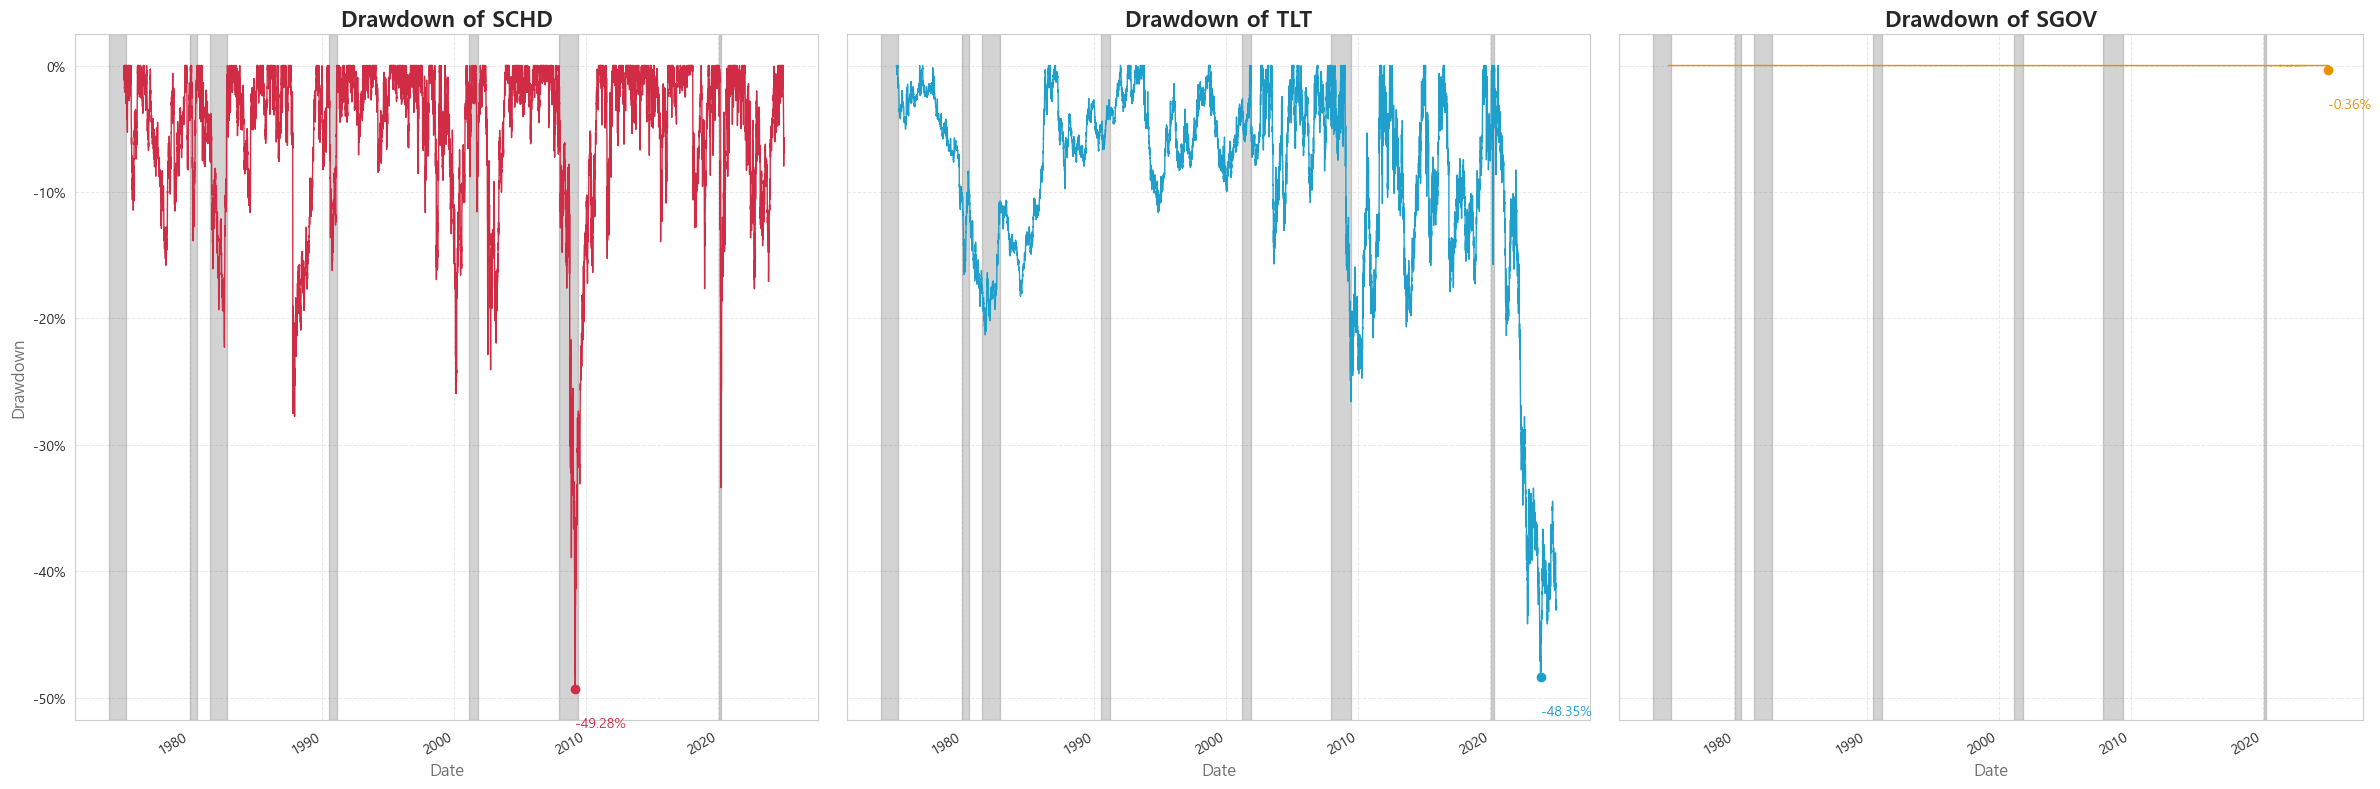

In [91]:
gm.drawdown_plot(plot_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']], highlight_periods=highlight_periods)

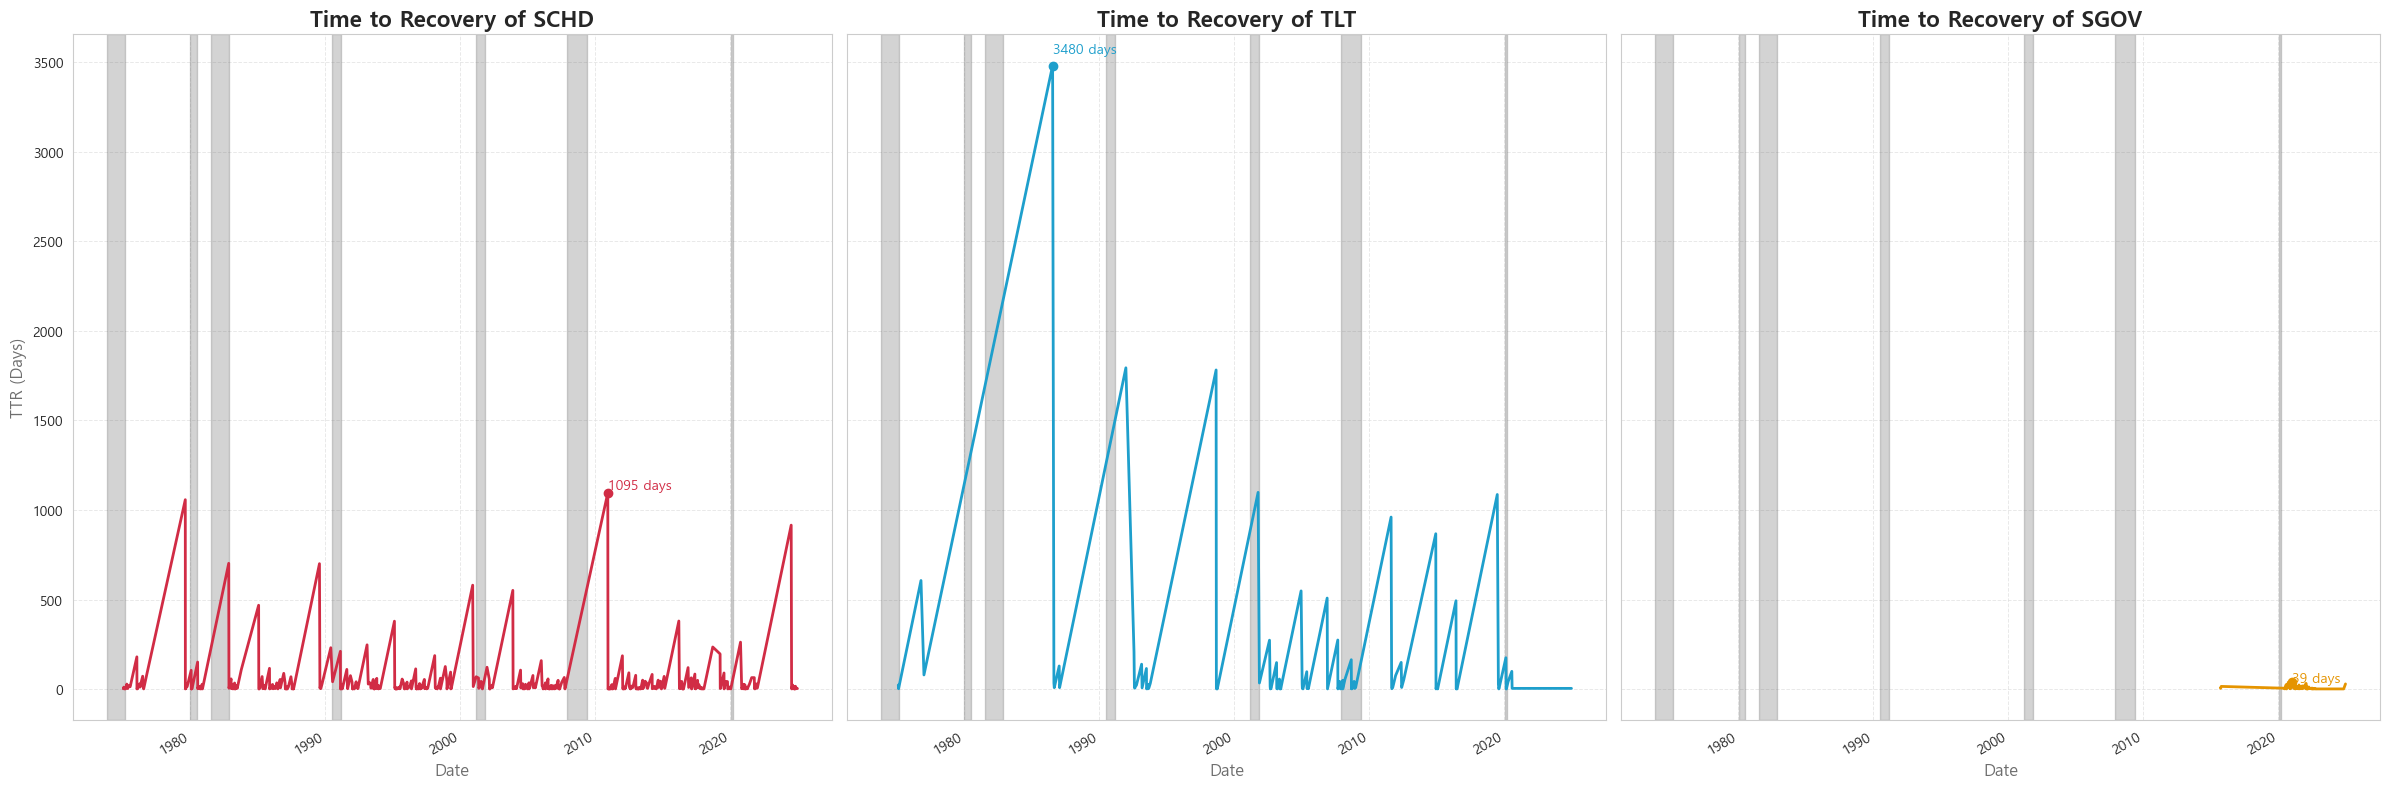

In [92]:
ttr_df = myfuncs.get_ttr_df(plot_df, assets)

gm.ttr_plot(ttr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

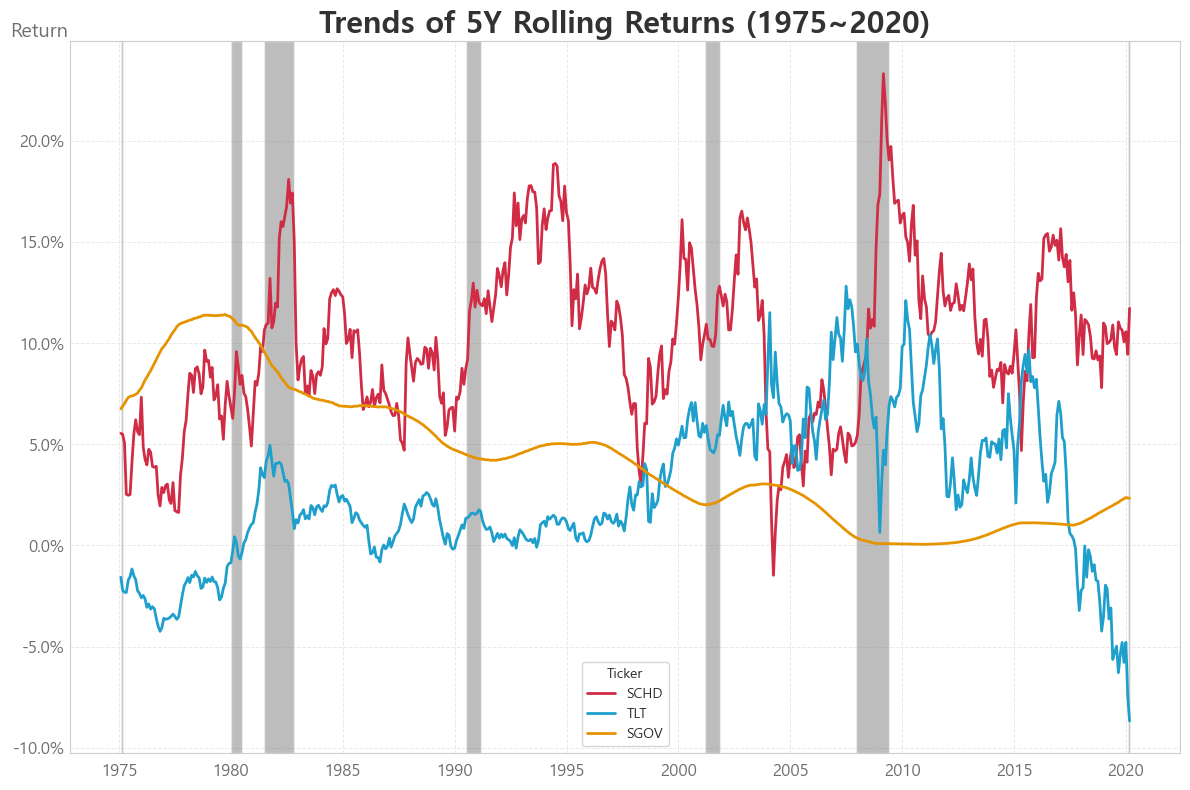

In [93]:
rr_df = myfuncs.get_rr_df(plot_df, assets)
gm.rr_trend_plot(rr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

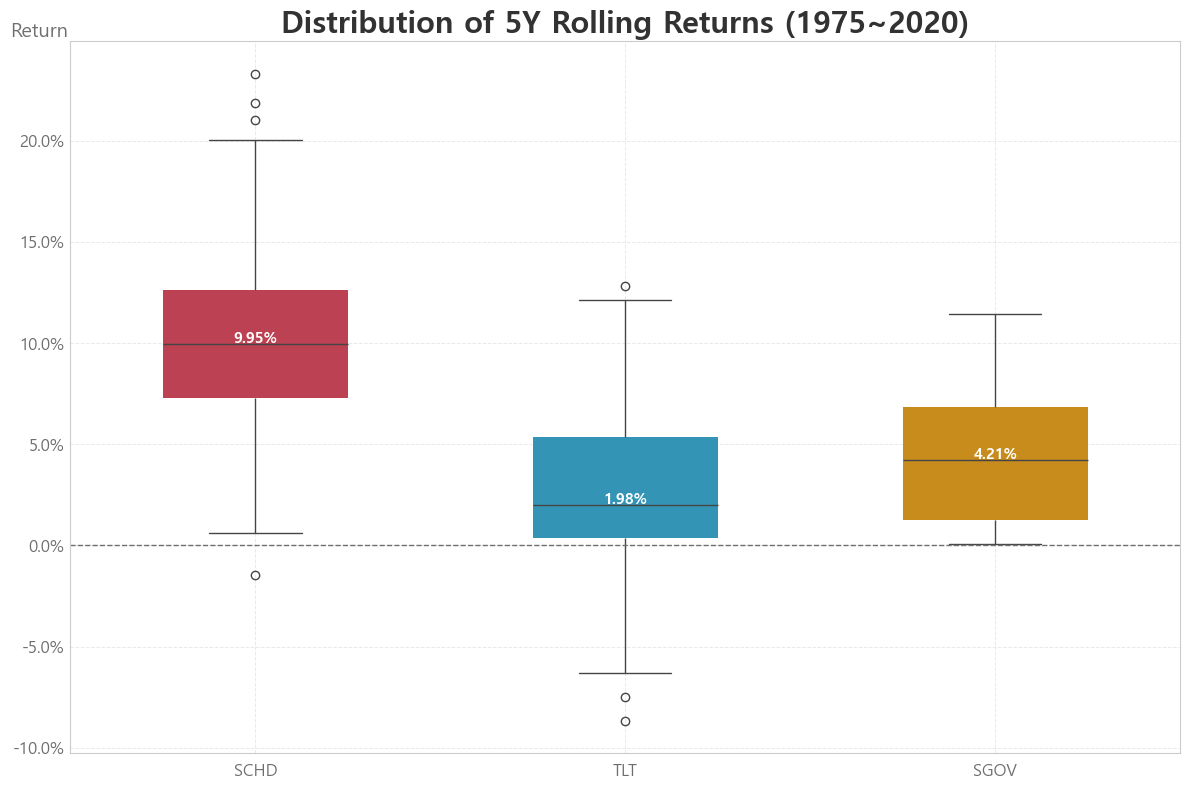

In [94]:
gm.rr_box_plot(rr_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

## Optimization

In [120]:
assets_port = assets + ['Gold']
port_assets_sp = ['Portfolio', 'SCHD']

In [101]:
corr_df = plot_df.pct_change()[assets_port].corr()

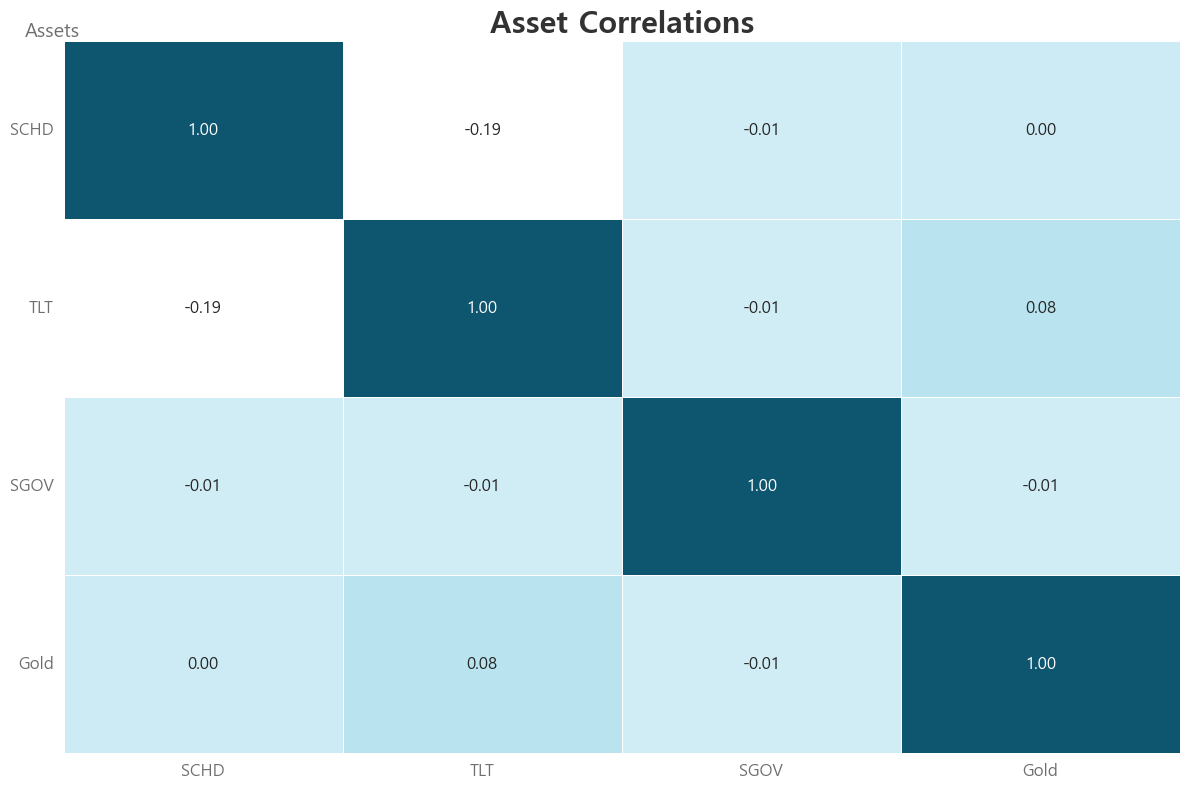

In [102]:
gm.corr_plot(corr_df, cmap=custom_cmap)

In [103]:
df_imp_m = plot_df[assets_port].resample('M').last()

In [104]:
allocator = portfolio_obtimizer.PortfolioAllocator()

cal_optimal => eg. process, obtimal, min_risk = cal_optimal(df)
eg. process, obtimal, min_risk = cal_optimal(df)


In [105]:
process, obtimal, min_risk = allocator.cal_optimal(df_imp_m, unit='monthly', rebalancing='m', d=10, min_edge=0)

총 286번 시행 예정
1번째 시행 중
100번째 시행 중
200번째 시행 중


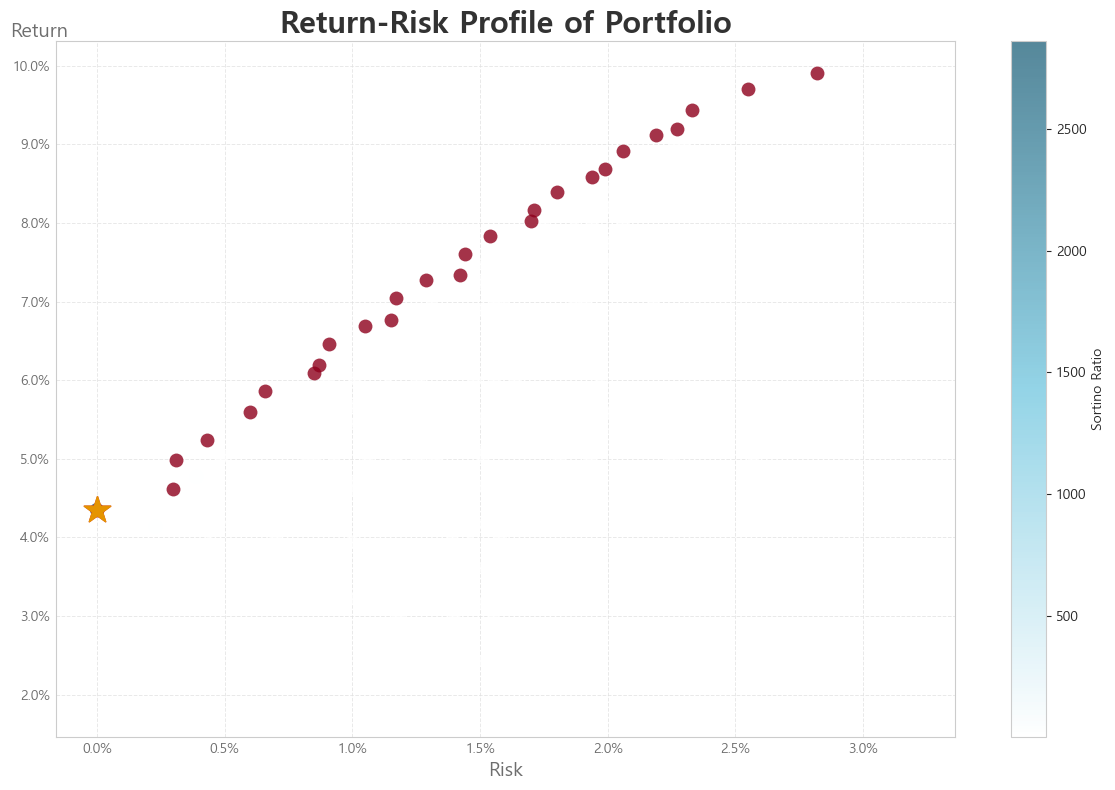

In [111]:
gm.portfilio_return_risk_profile_plot(process, min_risk, min_risk, cmap=custom_cmap)

In [118]:
## ratio 임의 조정시
ratio = [0.5, 0.0, 0.5, 0.0]
result = allocator.cal_rebalancing(plot_df[df_imp_m.columns], ratio=ratio, rebalancing='m', unit='daily')
result.rename(columns={'strategy':'Portfolio'}, inplace=True)
result = result/result.iloc[0]*100

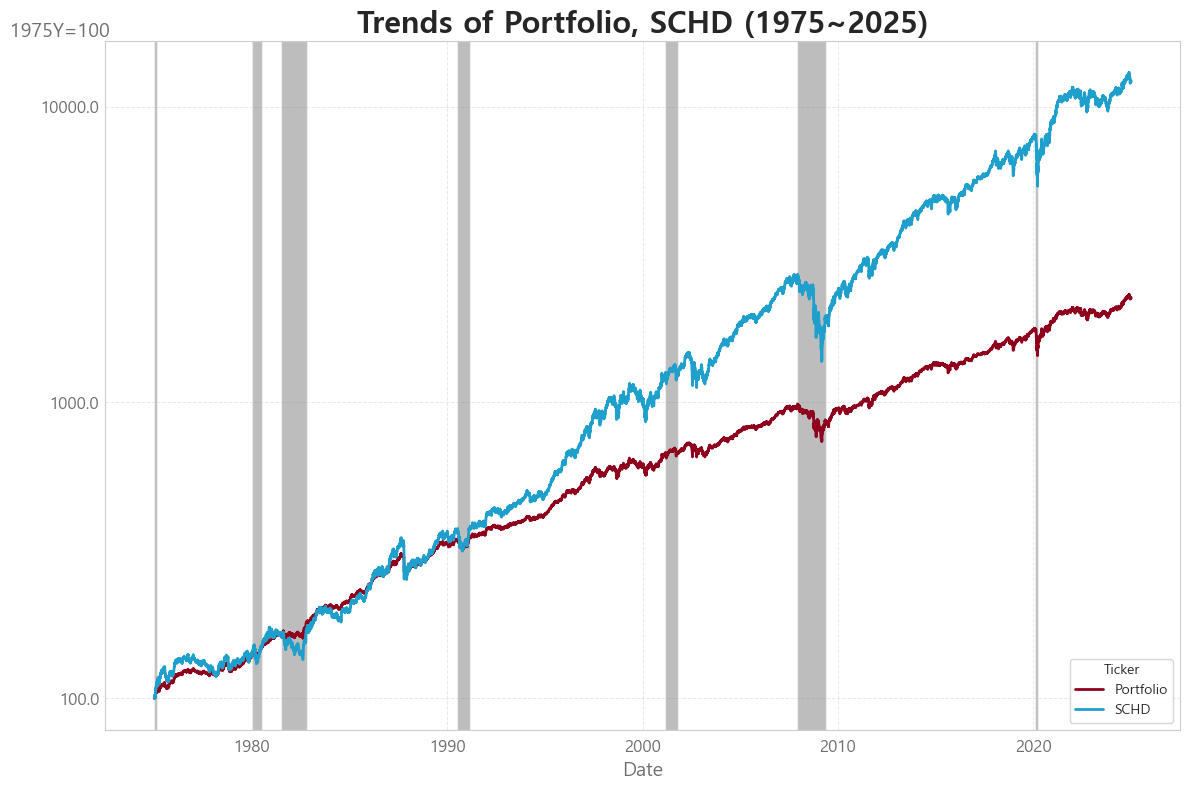

In [122]:
gm.trend_plot(result, port_assets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont']])

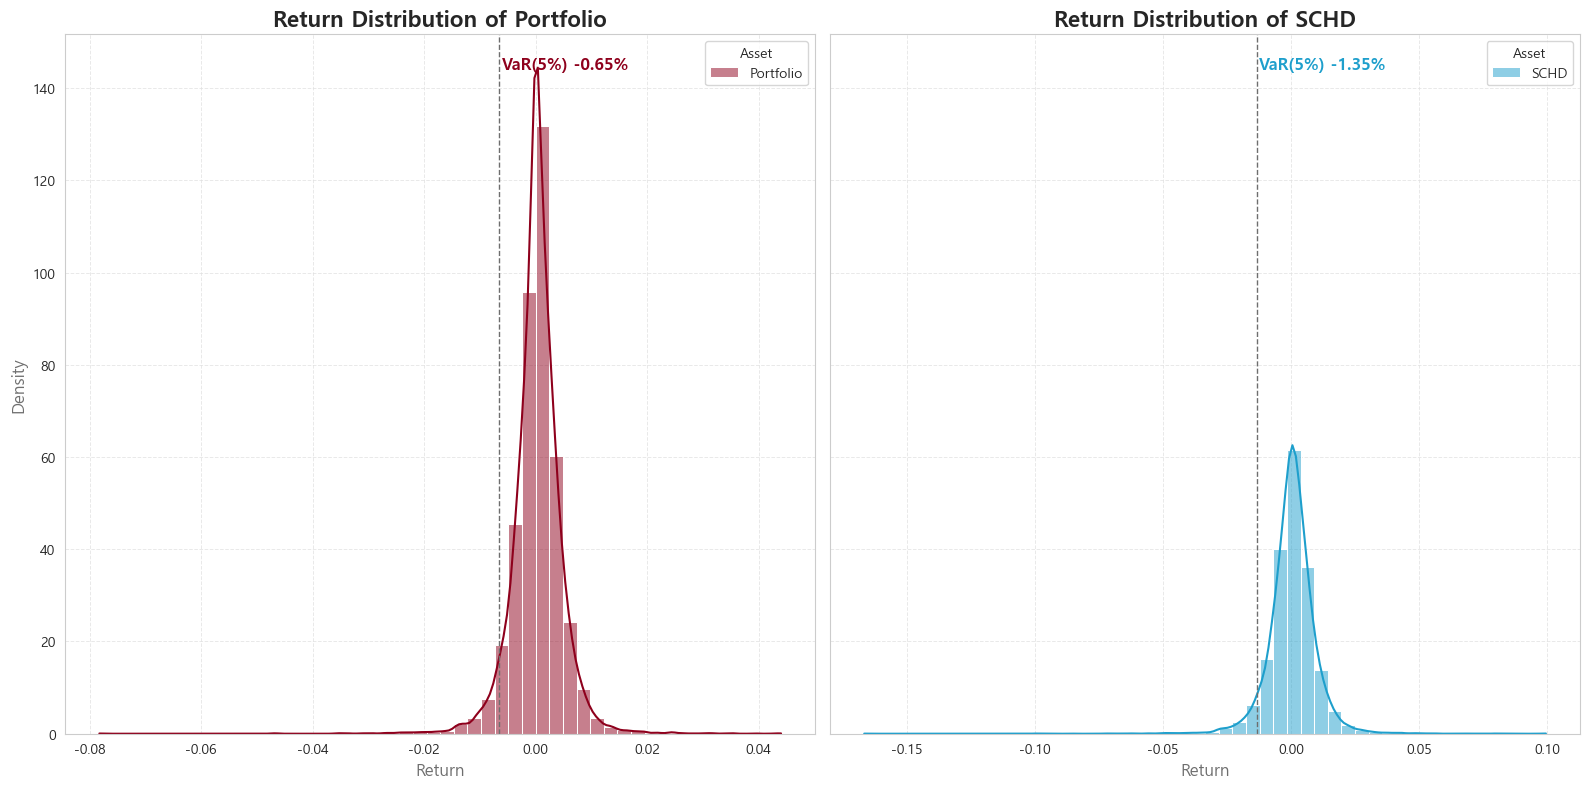

In [123]:
gm.asset_histogram_plot(result.pct_change(), port_assets_sp, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])

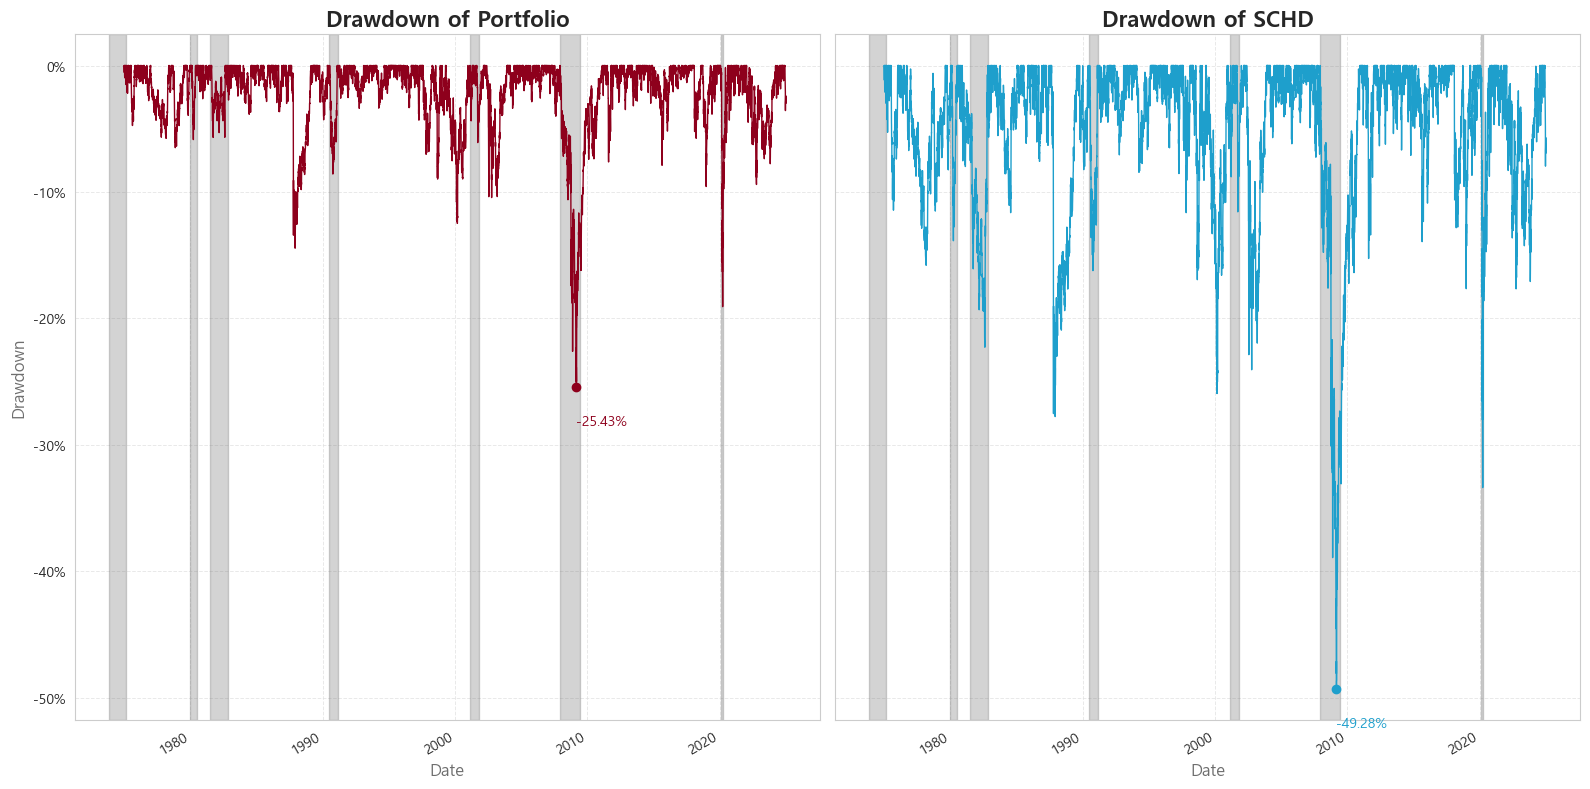

In [124]:
gm.drawdown_plot(result, port_assets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']])